# Word Embeddings

Embeddings is the technique to wrap word/sub-word/character information into bunch of numbers which represents the words in terms of its meaning.

**How do we derive the 'meaning' of these words?**

> Best way to represent meaning is based on the context of the word usage. (With context you can understand the meaning of the word). This implies the task here is to wrap the context of a word into vectors of n-dimensions (n could be 32,64,100,500.. etc)

**How does it work?**

> In practice, you have a vocabulary of allowed words; you choose this vocabulary in advance. For each vocabulary word, a look-up table contains its embedding. The embeddings are learned from data through training a model with an objective function.

> To account for unknown words (the ones which are not in the vocabulary), usually a vocabulary contains a special token UNK. Alternatively, unknown tokens can be ignored or assigned a zero vector.

**Types of Embedding learning**

- Count-Based Methods
- Prediction-Based Method

**What are we going to cover?**

```
We will explore the following Embeddings -

1. Word2Vec
  > Train the Word2Vec model
  > Visualize the word2vec with PCA
2. Glove - Global Vectors for Word Representation
  > Visualize the word2vec with t-SNE
  > Build a 'Similar Question predictor' model with embeddings
3. FastText
  > How is FastText different from other embeddings

```
**Why are the Word Embeddings important?**

> Embeddings which wrap the meaning and context of a word helps in
  - Classification tasks
  - Clustering
  - Semantic Representation
  - Dimensionality Reduction


In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Word2Vec: a Prediction-Based Embedding Method

This is one of the initial attempts at modelling word/tokens by the Google team back in 2013.

Original paper: https://arxiv.org/pdf/1301.3781

This is a directly extention of Bengio's paper this architecture, and focus just on the first step where the word vectors are learned using a simple model. ('A Neural Probabilistic Language Model'). But the major difference is that there is no hidden layer used.


**Word2Vec Architecture**

2 variants:

a) Skip-gram
- Goal: Predict context words given a target word (e.g., given "cat," predict "the," "sat")

```
Input (One-hot): [0, 0, ..., 1, ..., 0] (V=10,000)
     |
Embedding Layer (W): [V x D] -> [D=100]
     |
Output Layer (W'): [D x V] -> [V=10,000]
     |
Softmax/Negative Sampling -> Context word probabilities
```
b) Continuous Bag of Words (CBOW)
- Goal: Predict a target word given its context (e.g., given "the," "sat," predict "cat").

```
Inputs (One-hots): [0, 1, ..., 0], [0, 0, ..., 1], ... (C=4, V=10,000)
     |
Embedding Layer (W): [V x D] -> [D=100] per word -> Average -> [D]
     |
Output Layer (W'): [D x V] -> [V=10,000]
     |
Softmax/Negative Sampling -> Target word probability

```

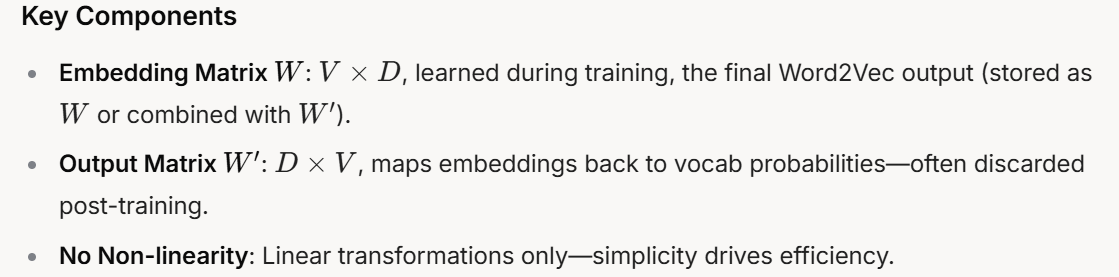

## Get the train data

The Quora questions dataset is used to to train the Word2Vec embedding

In [2]:
# This is a dataset with 537K questions from Quora. We will use this to train and analyze the Embeddings

# download the data:
!wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O ./quora.txt
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

--2025-03-04 05:29:18--  https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/p0t2dw6oqs6oxpd6zz534/quora.txt?rlkey=bjupppwua4zmd4elz8octecy9&dl=1 [following]
--2025-03-04 05:29:19--  https://www.dropbox.com/scl/fi/p0t2dw6oqs6oxpd6zz534/quora.txt?rlkey=bjupppwua4zmd4elz8octecy9&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb16a3b9bebedf9ee5a61051246.dl.dropboxusercontent.com/cd/0/inline/ClMIQNRBRivMvl-cPQm5Yy0X39YIRCM-CY_VuYAZvNdWCyojLKXIQ8tQbBd1bxSX9m8huzkLgvxi4ZpxOHJ5dUAl1Pemx4fjcYiTCS7OwMScFISK9bQmqEk0kWra9QRqPxs/file?dl=1# [following]
--2025-03-04 05:29:19--  https://ucb16a3b9bebedf9ee5a61051246.dl.dropboxusercontent.com/cd/0/inline/ClMIQNRBRiv

In [3]:
# Read the file and get the questions into a list
with open("./quora.txt", encoding="utf-8") as file:
    data = list(file)

print("Number of questions:", len(data))

Number of questions: 537272


In [4]:
# Show the first 5 questions
data[0:5]

["Can I get back with my ex even though she is pregnant with another guy's baby?\n",
 'What are some ways to overcome a fast food addiction?\n',
 'Who were the great Chinese soldiers and leaders who fought in WW2?\n',
 'What are ZIP codes in the Bay Area?\n',
 'Why was George RR Martin critical of JK Rowling after losing the Hugo award?\n']

> **Tokenization:** The process of breaking text into smaller units (tokens), such as words, subwords, or characters, for model input.

> This is a typical first step in an NLP task. The text we're working with is in raw format: with all the punctuation and smiles attached to some words, so a simple str.split won't do.

> Let's use **nltk** - a library that handles many NLP tasks like tokenization, stemming or part-of-speech tagging. Let us use this for tokenization

In [5]:
# lowercase everything and extract tokens with tokenizer
from nltk.tokenize import WordPunctTokenizer # This splits into tokens
tokenizer = WordPunctTokenizer()
print(data[0].lower())
print(tokenizer.tokenize(data[0].lower()))

can i get back with my ex even though she is pregnant with another guy's baby?

['can', 'i', 'get', 'back', 'with', 'my', 'ex', 'even', 'though', 'she', 'is', 'pregnant', 'with', 'another', 'guy', "'", 's', 'baby', '?']


In [6]:
# Get the tokens for all questions in the dataset
# data_tok should be a list of lists of tokens for each line in data.

data_tok = []
for each in data:
  data_tok.append([token.lower() for token in tokenizer.tokenize(each)])

print("Number of questions in data_tok:", len(data_tok))
print("Example after tokenization:", data_tok[50])

Number of questions in data_tok: 537272
Example after tokenization: ['what', 'tv', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


## Train Word2Vec

Genism has the Word2Vec model architecture. We can use this to train the model for our use case.

In [7]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=data_tok,
    vector_size=32,   # Dimensionality of word vectors- Default: 100 - Higher the value, longer it takes to train
    window=5,         # Context window size
    min_count=5,      # Ignore words with frequency less than 5
    # workers=4,        # Use 4 worker threads
    sg=1,             # Use skip-gram (1) or CBOW (0)
    negative=5,       # Number of negative samples
    epochs=10,        # Number of iterations over the corpus - You can train longer to optimize for a specific task
    # alpha=0.03      # initial learning rate
).wv                  # vw: This object essentially contains the mapping between words and embeddings.
                      # After training, it can be used directly to query those embeddings in various ways.


In [8]:
# now you can get word vectors !
# This vectors will be of dimension 32 since we defined the vector_size to be 32
model.get_vector('anything')

array([-0.20453316, -0.4937044 , -0.43673772,  0.03009441,  0.8297953 ,
       -0.06971624,  0.20393047, -0.36906576, -0.27666393,  0.3326753 ,
        0.14129972, -0.04411283,  0.19901273, -0.9519131 , -0.41626546,
       -0.02673633,  0.424371  ,  0.21859157,  0.2012907 ,  0.29684955,
       -0.12918818,  0.80186224,  0.81680244, -0.3914968 ,  0.18833008,
       -0.21943145, -0.40696165, -0.30445033, -0.17435387, -0.5813831 ,
       -0.480222  , -0.2979004 ], dtype=float32)

In [9]:
model.get_vector('car')

array([ 0.09027763, -0.00704316,  0.11192285, -0.73552394, -0.5942219 ,
       -0.42419994,  0.51428795,  0.8263424 , -0.56605005, -0.03759528,
       -0.62776977, -0.64057916, -0.44717333, -0.35835102, -0.86086977,
       -0.00274875, -0.13848619, -0.1308318 , -0.0294717 ,  0.5006798 ,
       -0.04560613,  0.6647168 ,  1.0423399 , -0.18199518,  0.53517604,
        0.47728497, -0.31227624,  0.10395233, -0.49165407, -0.33302516,
       -0.78555167,  0.93451643], dtype=float32)

In [10]:
# Let us compute how close two vectors are to each other.
# Cosine similarity is normalized dot product between two vectors - Higher the value Higher is their similarity
def cosine_similarity(a, b):
    """Calculates the cosine similarity between two vectors."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [11]:
word_1 = 'car'
word_2 = 'bike'
c_sim = round(cosine_similarity(model.get_vector(word_1), model.get_vector(word_2)),4)
print(f"Cosine similarity between '{word_1}' and '{word_2}':", c_sim)

Cosine similarity between 'car' and 'bike': 0.8689


In [12]:
word_1 = 'car'
word_2 = 'milk'
c_sim = round(cosine_similarity(model.get_vector(word_1), model.get_vector(word_2)),4)
print(f"Cosine similarity between '{word_1}' and '{word_2}':", c_sim)

Cosine similarity between 'car' and 'milk': 0.4938


**Clearly bike is more similar to car than milk**

In [13]:
word_1 = 'man'
word_2 = 'woman'
c_sim = round(cosine_similarity(model.get_vector(word_1), model.get_vector(word_2)),4)
print(f"Cosine similarity between '{word_1}' and '{word_2}':", c_sim)

Cosine similarity between 'man' and 'woman': 0.9454


In [14]:
word_1 = 'boy'
word_2 = 'girl'
c_sim = round(cosine_similarity(model.get_vector(word_1), model.get_vector(word_2)),4)
print(f"Cosine similarity between '{word_1}' and '{word_2}':", c_sim)

Cosine similarity between 'boy' and 'girl': 0.9339


**Man-woman and boy-girl vectors are similar to each other, which is what we expect**

Looks like the embeddings have been able to capture the meaning based on context reaonably well with Word2Vec architecture

In [15]:
# The 'most_similar' method gives the top 10 closest vector to a given vector
model.most_similar('car')

[('motorcycle', 0.9053753018379211),
 ('truck', 0.9019933938980103),
 ('tire', 0.8823414444923401),
 ('vehicle', 0.871796190738678),
 ('bike', 0.8689169883728027),
 ('bicycle', 0.8568090200424194),
 ('outlet', 0.8412826657295227),
 ('heater', 0.8218958377838135),
 ('parked', 0.8177747130393982),
 ('garage', 0.8171538710594177)]

In [16]:
model.most_similar('milk')

[('curd', 0.9118748307228088),
 ('powder', 0.9055805802345276),
 ('banana', 0.9054418802261353),
 ('rice', 0.9025349617004395),
 ('oats', 0.900055468082428),
 ('chicken', 0.8947225213050842),
 ('bread', 0.8919790387153625),
 ('fruit', 0.8884207010269165),
 ('garlic', 0.8850941061973572),
 ('powdered', 0.8839070796966553)]

## Visualizing word vectors with Word2Vec

One way to see if our vectors are any good is to plot them. Thing is, those vectors are in 30D+ space and we humans are more used to 2-3D.

Luckily, we machine learners know about dimensionality reduction methods.

Let's use that to plot 100 most frequent words

## **Linear projection: PCA**

The simplest linear dimensionality reduction method is Principial Component Analysis.

In geometric terms, PCA tries to find axes along which most of the variance occurs. The "natural" axes, if you wish.

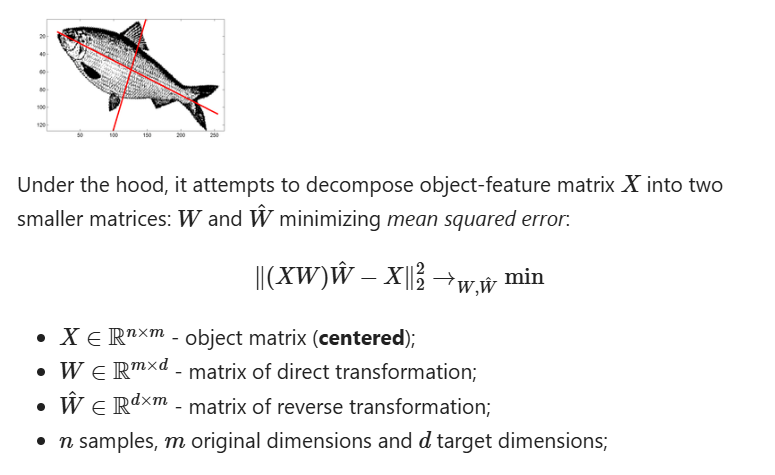

In [17]:
n = 1000
words = model.index_to_key[:n]
print(words[:10])

word_vectors = np.array([model.get_vector(each) for each in words])
word_vectors.shape

['?', 'the', 'what', 'is', 'a', 'i', 'to', 'in', 'how', 'of']


(1000, 32)

In [18]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), 32)
assert np.isfinite(word_vectors).all()

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
# Fit PCA to get 2 components
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

scaler = StandardScaler()
word_vectors_pca = scaler.fit_transform(word_vectors_2d)

**Let's draw it!**

In [21]:
! pip install -q bokeh

In [22]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, words_to_label,title, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """Draws an interactive plot with word labels next to data points."""
    if isinstance(color, str): color = [color] * len(x)
    data_source = ColumnDataSource({'x': x, 'y': y, 'color': color, 'words': words, **kwargs})

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height,title=title)
    fig.title.text_align = 'center'
    fig.title.text_font_size = '20pt'

    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    # Add word labels for specific words
    # words_to_label = ['ios', 'android', 'windows']
    words_to_label_ind = [i for i, w in enumerate(words) if w in words_to_label]
    if words_to_label_ind:  # Only if there are matches
        labeled_data = {
            'x': x[words_to_label_ind],
            'y': y[words_to_label_ind],
            'words': [words[i] for i in words_to_label_ind]
        }
        label_source = ColumnDataSource(labeled_data)
        labels = LabelSet(x='x', y='y', text='words', source=label_source,
                          text_font_size='8pt', x_offset=5, y_offset=5)
        fig.add_layout(labels)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))

    if show: pl.show(fig)
    # return fig

In [23]:
# draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1],token=words)
words_to_label = ['ios', 'android', 'windows','man', 'woman', 'boy', 'girl', 'king', 'queen']
title = "          2D Word Embeddings with Word2Vec "
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1],words_to_label,title, token=words)
# hover a mouse over there and see if you can identify the clusters

# GloVe - Global Vectors for Word Representation

> GloVe stands for Global Vectors for Word Representation. Introduced in the 2014 paper, is a count-based method for learning word embeddings, distinct from the predictive neural network approaches like Word2Vec.

> Unlike Word2Vec’s shallow neural net or Bengio’s feedforward model, GloVe doesn’t use a traditional neural architecture with layers. Instead, it leverages a co-occurrence matrix extracted from a corpus and optimizes a weighted least-squares objective to produce embeddings that capture global word relationships.

**Goal: Learn word embeddings where the dot product of two word vectors approximates the logarithm of their co-occurrence probability in a corpus.**

```
Corpus -> Co-occurrence Matrix X [V x V]
     |
Weighting f(X_ij) -> Weighted X
     |
Optimization: J = Σ f(X_ij) (w_i^T w̃_j + b_i + b̃_j - log(X_ij))^2
     |
Output: W [V x D] + W̃ [V x D] -> Combined Embeddings [V x D]

```

**Here we will be using a pre-trained model to plot the embedding vectors for the words of our interest.**

In [24]:
import gensim.downloader as api
model_glove = api.load('glove-twitter-100') # This is a pre-trained model

In [25]:
model_glove.most_similar(positive=["apple", "computer"], negative=["fruit"])

[('microsoft', 0.7363232970237732),
 ('laptop', 0.7193729281425476),
 ('google', 0.6976737380027771),
 ('iphone', 0.6843403577804565),
 ('ipad', 0.682321310043335),
 ('sony', 0.6798533797264099),
 ('samsung', 0.6794281005859375),
 ('nokia', 0.6767431497573853),
 ('computers', 0.6762350797653198),
 ('desktop', 0.6704712510108948)]

In [26]:
model_glove.most_similar(positive=["apple", "fruit"], negative=["computer"])

[('mango', 0.7267351150512695),
 ('fruits', 0.7044064998626709),
 ('strawberry', 0.6844577193260193),
 ('peach', 0.6761018633842468),
 ('sour', 0.6754433512687683),
 ('coconut', 0.6604940295219421),
 ('vanilla', 0.6548364162445068),
 ('smoothie', 0.6492083668708801),
 ('almond', 0.6486080884933472),
 ('lemon', 0.6476317644119263)]

In [27]:
model_glove.most_similar(positive=["learning"])

[('teaching', 0.8573681712150574),
 ('learn', 0.824956476688385),
 ('education', 0.7550071477890015),
 ('lessons', 0.7518463730812073),
 ('teach', 0.7460376620292664),
 ('lesson', 0.7365145087242126),
 ('learned', 0.7316320538520813),
 ('skills', 0.7287312150001526),
 ('writing', 0.7232455611228943),
 ('experience', 0.7218447923660278)]

## **Visualize phrases with t-SNE**


PCA is nice but it's strictly linear and thus only able to capture coarse high-level structure of the data.

If we instead want to focus on keeping neighboring points near, we could use TSNE, which is itself an embedding method. Here you can read more on TSNE.

In [28]:
# Let's use the same words and get corresponding Glove vectors

# n = 1000
# words = model.index_to_key[:n]
print(words[:10])

# Some keys are not present in Glove pre_trained model. Removing them from words
# for each in words:
#   try:
#     temp_vec = model_glove.get_vector(each)
#   except:
#     words.remove(each)
# len(words)
for each in words:
  if each not in model_glove.key_to_index:
    words.remove(each)
if '2017'in words: words.remove('2017')
len(words)

['?', 'the', 'what', 'is', 'a', 'i', 'to', 'in', 'how', 'of']


968

In [29]:
word_vectors_glove = np.array([model_glove.get_vector(each) for each in words])
word_vectors_glove.shape

(968, 100)

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_2d = tsne.fit_transform(word_vectors_glove)
scaler = StandardScaler()

word_vector_2d_glove = scaler.fit_transform(tsne_2d)

In [31]:
words_to_label = ['ios', 'android', 'windows','man', 'woman', 'boy', 'girl']
title = "          2D Word Embeddings with Glove"
draw_vectors(word_vector_2d_glove[:, 0], word_vector_2d_glove[:, 1],words_to_label,title, color='green',token=words)

> Interesting to see ios, android and windows all clustered together again

> man, boy and girl are clustered together whereas woman is far away pretty strange though


## Build a Similar Questions Predictor model using Glove embeddings

Word embeddings can also be used to represent short phrases. The simplest way is to take an average of vectors for all tokens in the phrase with some weights.

This trick is useful to identify what data are you working with: find if there are any outliers, clusters or other artefacts.

Let's try this new hammer on our data!

In [32]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros

    vector = np.zeros([model_glove.vector_size], dtype='float32')

    # YOUR CODE
    check = phrase.lower()
    check = check.split(' ')
    data_check_tok = []
    for each in check:
      data_check_tok.extend(tokenizer.tokenize(each))
    ct = 0
    for each in data_check_tok:
      # print(each)
      if each in model_glove.key_to_index:
        vector +=model_glove.get_vector(each)
        ct +=1
    if ct == 0:
      return vector
    return vector/ct

In [33]:
get_phrase_embedding("thisisgibberish")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [34]:
vector = get_phrase_embedding("I'm very sure. This never happened to me before...")
vector

array([ 0.31807372,  0.25188074,  0.06748973,  0.07918166, -0.20551686,
        0.3099363 ,  0.12886   , -0.06323332,  0.1167265 ,  0.1529691 ,
       -0.02558171, -0.22829592, -4.4815    ,  0.02976158, -0.12603833,
       -0.1181161 , -0.23754632, -0.02389293, -0.47764084, -0.03727125,
        0.0933293 , -0.11675651, -0.07968461,  0.16103767,  0.22593975,
       -0.9288166 , -0.13147809, -0.27092585,  0.32907042, -0.12769467,
       -0.1002182 ,  0.05345418, -0.33383527,  0.16147001,  0.05949384,
        0.13145241,  0.04188244, -0.11879817,  0.09030958, -0.02781658,
       -1.0278689 ,  0.00457059,  0.21854158, -0.06651367,  0.23628668,
       -0.14505692,  0.17416383, -0.08423841, -0.12737857, -0.01618933,
       -0.16621883,  0.12946318,  0.17684542, -0.01754692,  0.12413007,
        0.01527582, -0.11908681,  0.11422   ,  0.15738223,  0.09719244,
        0.05083408,  0.0163896 ,  0.03656067, -0.11753249,  0.25182876,
       -0.10408742, -0.11623914, -0.11769509, -0.22145198,  0.07

In [35]:
# let's only consider ~5k phrases for a first run.
chosen_phrases = data[::len(data) // 1000]
chosen_phrases[0]

"Can I get back with my ex even though she is pregnant with another guy's baby?\n"

In [36]:
# compute vectors for chosen phrases
phrase_vectors = np.array([get_phrase_embedding(phrase) for phrase in chosen_phrases])

In [37]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model_glove.vector_size)

In [38]:
# map vectors into 2d space with pca, tsne or your other method of choice
# don't forget to normalize
phrase_vectors_2d = TSNE().fit_transform(phrase_vectors)
phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

**Visualizing phrases**

In [39]:
title = "   2D representation of Embedded Phrases"
draw_vectors(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1],[],title = title,
             phrase=[phrase[:50] for phrase in chosen_phrases],
             radius=20,)

## Similar Questions Predictor model

Finally, let's build a simple "similar question" engine with phrase embeddings we've built.

In [41]:
# compute vector embedding for all lines in data
data_vectors = np.array([get_phrase_embedding(l) for l in data])

In [42]:
def find_nearest(query, k=10):
    """
    given text line (query), return k most similar lines from data, sorted from most to least similar
    similarity should be measured as cosine between query and line embedding vectors
    hint: it's okay to use global variables: data and data_vectors. see also: np.argpartition, np.argsort
    """
    # YOUR CODE
    query_vec = get_phrase_embedding(query)
    normalized_data_vectors = data_vectors / np.linalg.norm(data_vectors, axis=1, keepdims=True)
    normalized_query_vector = query_vec / np.linalg.norm(query_vec)
    c_sim = np.dot(normalized_data_vectors,normalized_query_vector)

    k = 10
    top_k_indices = np.argpartition(-c_sim, k)[:k]
    top_k_indices = top_k_indices[np.argsort(-c_sim[top_k_indices])]
    return [data[i] for i in top_k_indices]

In [43]:
results = find_nearest(query="How do i enter the matrix?", k=10)
print(''.join(results))

How do I get to the dark web?
What should I do to enter hollywood?
How do I use the Greenify app?
What can I do to save the world?
How do I win this?
How do I think out of the box? How do I learn to think out of the box?
How do I find the 5th dimension?
How do I use the pad in MMA?
How do I estimate the competition?
What do I do to enter the line of event management?



## Similar Questions based on Embedding similarity

In [44]:
results = find_nearest(query="Where is Donald Trump from?", k=10)
print(''.join(results))

How old is Donald Trump?
Is there only one Donald Trump?
Who is Donald Trump?
How is Donald Trump in person?
Why is Donald Trump going to Mexico?
Is Donald Trump the owner of McDonalds?
What is Donald Trump like in person?
What does Donald Trump think of India?
What does India think of Donald Trump?
Why is Donald Trump awesome?



# FastText - embedding based on subword


> FastText is a word embedding technique developed by Facebook AI Research (FAIR) and introduced in 2016 by Piotr Bojanowski, Edouard Grave, Armand Joulin, and Tomas Mikolov (of Word2Vec fame).

> It builds on Word2Vec by incorporating subword information, making it particularly effective for morphologically rich languages, rare words, and out-of-vocabulary (OOV) terms.

> Unlike traditional word embeddings that treat each word as a single unit, FastText represents words as bags of character n-grams, enhancing its ability to capture meaning at a finer granularity.


**Architecture**

```
Input: "cat" -> [<ca, cat, at>]
     |
Embedding Layer (W): [V x D] -> Sum/Avg -> [D=300]
     |
Output Layer (W'): [D x V] -> [V]
     |
Softmax/Negative Sampling -> Context word probs
```

Subword Info: Unlike Word2Vec’s word-level embeddings, FastText uses n-grams (e.g., 3-6 chars), enabling OOV handling.
Example: "unseen" → <un, uns, nse, see, een> → embedding via sum of known n-grams.

FastText’s strength lies in its subword information, enabling it to handle out-of-vocabulary (OOV) words, capture morphological similarities, and perform efficiently.

## 1. Generate Embeddings for OOV Words - especially when typos occur


In [45]:
import os
model_path = "/content/cc.en.300.bin"
if not os.path.exists(model_path):
    print("Downloading FastText .bin model...")
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -O /content/cc.en.300.bin.gz
    !gunzip /content/cc.en.300.bin.gz

In [46]:
# Load full FastText model
from gensim.models import FastText
model_fasttext = FastText.load_fasttext_format(model_path)

# Verify model and embeddings
print(f"Vocab size: {len(model_fasttext.wv.key_to_index)}")  # ~2M
print(f"Vector size: {model_fasttext.wv.vector_size}")      # 300
print(f"Embedding for 'cat': {model_fasttext.wv['cat'][:5]}")
print(f"Embedding for 'catzz': {model_fasttext.wv['catzz'][:5]}")  # OOV works!

Vocab size: 2000000
Vector size: 300
Embedding for 'cat': [ 0.08105576 -0.02083234 -0.03326922  0.28555283  0.13959414]
Embedding for 'catzz': [ 0.03587727 -0.01561755 -0.05628482  0.09459505  0.10735092]


In [47]:
# Test OOV words
oov_words = ['catzz', 'andriod', 'instalation']  # Typos not in vocab

print("Checking for embeddings from Glove Model:")
for word in oov_words:
  try:
    embedding = model_glove.wv[word][:5]
    print(f"Embedding for '{word}': {embedding}")
  except:
    print(f"Embeddings not available for the word '{word}'")

print("\nChecking for embeddings from FastText Model:")

for word in oov_words:
  try:
    embedding = model_fasttext.wv[word][:5]  # First 5 dims for brevity
    print(f"Embedding for '{word}': {embedding}")
  except:
    print(f"Embeddings not available for the word '{word}'")

Checking for embeddings from Glove Model:
Embeddings not available for the word 'catzz'
Embeddings not available for the word 'andriod'
Embeddings not available for the word 'instalation'

Checking for embeddings from FastText Model:
Embedding for 'catzz': [ 0.03587727 -0.01561755 -0.05628482  0.09459505  0.10735092]
Embedding for 'andriod': [0.0778043  0.00111201 0.0460443  0.04910706 0.04300612]
Embedding for 'instalation': [-0.01877421 -0.00149625  0.01647838  0.02764789 -0.0111602 ]


## 2. Morphological Similarity

In [48]:
morph_pairs = [('play', 'playing'), ('run', 'running'), ('cat', 'cats')]
for w1, w2 in morph_pairs:
    sim = model_fasttext.wv.similarity(w1, w2)
    print(f"Similarity between '{w1}' and '{w2}': {sim:.4f}")

Similarity between 'play' and 'playing': 0.7612
Similarity between 'run' and 'running': 0.7398
Similarity between 'cat' and 'cats': 0.8350


## 3. Basic Text Classification

In [50]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Dummy data (Tiny Stories-like)
sentences = [("happy day", 1), ("sad night", 0)]
X = [np.mean([model_fasttext.wv[word] for word in sent.split()], axis=0) for sent, _ in sentences]
y = [label for _, label in sentences]

clf = LogisticRegression().fit(X, y)
# test_sent = "joyful morning"
test_sent = "bad morning"
test_vec = np.mean([model_fasttext.wv[word] for word in test_sent.split()], axis=0)
pred = clf.predict([test_vec])[0]
print(f"Prediction for '{test_sent}': {'Positive' if pred == 1 else 'Negative'}")

Prediction for 'bad morning': Negative


## 4. Cosine Distance Heatmap

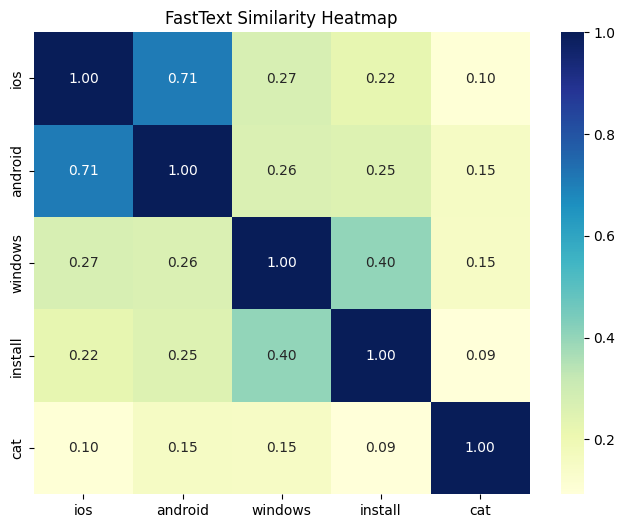

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
words = ['ios', 'android', 'windows', 'install', 'cat']
sim_matrix = np.zeros((len(words), len(words)))
for i, w1 in enumerate(words):
    for j, w2 in enumerate(words):
        sim_matrix[i, j] = model_fasttext.wv.similarity(w1, w2)

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=words, yticklabels=words)
plt.title("FastText Similarity Heatmap")
plt.savefig("fasttext_heatmap.png")
plt.show()